# This repo contains the following:
- Code for CNN-based classification for MNIST Dataset
- Code for Pointnet classification for MNIST3D Dataset
- Code for Fusion-based classification for MNIST and MNIST3D Dataset

# Load Libraries

In [1]:
# Set-up and load libraries
import os
import glob
import h5py
import numpy as np
import pandas as pd


# Tensorflow and Keras...
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import GlobalMaxPooling1D
from keras.utils import plot_model
from keras.models import Model


# plot and others...
from matplotlib import pyplot as plt
import trimesh
import seaborn as sns
from matplotlib.animation import FuncAnimation
from sklearn.metrics import classification_report
# set seed
tf.random.set_seed(1234)

2022-12-04 01:54:19.158039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Config and parameters

In [2]:
num_cloud_points = 1024
point_cloud_size = (num_cloud_points, 3)
image_size = (30, 30, 1)
num_classes = 10


epochs = 500
batch_size = 32
patience = 5

# run_type = 'demo'
run_type = 'full'

# Load MNIST (2D + 3D) Dataset

In [3]:
# data directory
DATADIR = '../data/multimodal/mnist3d/'

In [4]:
def load_data(data_type, num_pcs):
    '''
    Load train and test data: 2D images, 3D point clouds and labels

    arg:
    data_type: 'train' or 'test'

    return:
    x_2d: 2D images 
    x_3d: 3D pointcloud
    y: labels
    '''
    print(f"Loading {data_type} data......")

    with h5py.File(DATADIR + f'{data_type}_point_clouds.h5', 'r') as points_dataset:

        # Array to store data...
        x_2d = []
        x_3d = []
        y = [] 

        # Looping over the whole dataset..
        for i, (key, sample) in enumerate(points_dataset.items()):
            
            # Saving images...
            x_2d.append(sample['img'][:])

            # Sampling point cloud and saving...
            pointCloud = sample['points'][:]
            num_of_rows = pointCloud.shape[0]
            random_ind = np.random.choice(num_of_rows, size=num_pcs, replace=False)
            pointCloud = pointCloud[random_ind, :]
            x_3d.append(pointCloud)

            # Ssaving labels...
            y.append(sample.attrs['label'])

    # converting to np array...
    x_2d = np.stack(x_2d).reshape(-1, 30, 30, 1)
    x_3d = np.stack(x_3d)
    
    # convert class vectors to binary class matrices
    y = keras.utils.to_categorical(np.array(y), num_classes)  

    # Dropping samples if running as a demo...
    
    # Total samples..............
    total_samples = x_3d.shape[0]
    # Taking random indices for resampling
    random_indices = np.arange(total_samples)
    np.random.shuffle(random_indices)

    # checking the run_type
    if run_type == 'demo':
        print(f"Original shape of 2D samples: {x_2d.shape}")
        print(f"Original shape of 3D samples: {x_3d.shape}")
        demo_samples = 100
        random_indices = random_indices[0:demo_samples]

    # Selecting training and test samples...
    x_2d = x_2d[random_indices]
    x_3d = x_3d[random_indices]
    y = y[random_indices]
   
    # Done loading and processing dataset...
    # print(f"{data_type} data loaded...!")
    print(f"_______________________________________________")
    print(f"Loaded shape of 2D samples: {x_2d.shape}")
    print(f"Loaded shape of 3D samples: {x_3d.shape}")
    print("\n")
    # return image, pointclouds, and labels
    return x_2d, x_3d, y

In [5]:
# Loading training data
x_train_2d, x_train_3d, y_train = load_data(data_type = 'train', num_pcs = num_cloud_points)
y_train_digit = np.argmax(y_train, axis=1) # Convert one-hot to index

# Loading test data
x_test_2d, x_test_3d, y_test = load_data(data_type = 'test', num_pcs = num_cloud_points)
y_test_digit = np.argmax(y_test, axis=1) # Convert one-hot to index


Loading train data......
_______________________________________________
Loaded shape of 2D samples: (5000, 30, 30, 1)
Loaded shape of 3D samples: (5000, 1024, 3)


Loading test data......
_______________________________________________
Loaded shape of 2D samples: (1000, 30, 30, 1)
Loaded shape of 3D samples: (1000, 1024, 3)




# Creating Models to extract features

In [6]:
# Functions for building the models.......

# Convolution with batch normalization...
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# Dense with batch normalization...
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# Transormation Network (T-Net)...
def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    # reg = OrthogonalRegularizer(num_features)
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        # activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


In [7]:
# CNN Model to extract 128 features from 2D MNIST dataset
inputs_2D = Input(shape=image_size)
feat_2d = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs_2D)
feat_2d = MaxPooling2D(pool_size=(2, 2))(feat_2d)
feat_2d = Conv2D(64, kernel_size=(3, 3), activation="relu")(feat_2d)
feat_2d = MaxPooling2D(pool_size=(2, 2))(feat_2d)
feat_2d = Flatten()(feat_2d)
feat_2d = Dropout(0.3)(feat_2d)
feat_2d = Dense(128, activation="relu")(feat_2d)
# Creating the model to extract features from input images
model_feat_ext_2D = Model(inputs=inputs_2D, outputs=feat_2d,  name="feature-extractor-2D")
print(model_feat_ext_2D.summary())

Model: "feature-extractor-2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)     

2022-12-04 01:54:46.627009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Pointnet model to extract 128 features from 3D MNIST dataset
inputs_3D = Input(shape= point_cloud_size)

feat_3D = tnet(inputs_3D, 3)
feat_3D = conv_bn(feat_3D, 32)
feat_3D = conv_bn(feat_3D, 32)
feat_3D = tnet(feat_3D, 32)
feat_3D = conv_bn(feat_3D, 32)
feat_3D = conv_bn(feat_3D, 64)
feat_3D = conv_bn(feat_3D, 512)
feat_3D = GlobalMaxPooling1D()(feat_3D)
feat_3D = dense_bn(feat_3D, 256)
feat_3D = Dropout(0.3)(feat_3D)
feat_3D = dense_bn(feat_3D, 128)
# Creating the model to extract features from input point cluds
model_feat_ext_3D = Model(inputs=inputs_3D, outputs=feat_3D,  name="feature-extractor-3D")
print(model_feat_ext_3D.summary())


Model: "feature-extractor-3D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 32)     128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1024, 32)     0           ['batch_normal

In [9]:
def train_and_evaluate(model_name, model, x_train, x_test, y_train, y_test, epochs, batch_size, patience):
    """  
    arg: model and other info
    return: trained model & eval data
    """
    # Train and evaluate model
    # Starting the training...
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)
    history = model.fit(x_train, y_train, batch_size=batch_size
    , epochs=epochs, validation_split=0.1, callbacks=[callback])

    # Evaluate model on test data...
    accuracy = model.evaluate(x_test, y_test, batch_size=56)[1]
    print(f"Test Accuracy of {model_name}: {np.round(accuracy*100,5)}%")

    plt.figure()
    plt.plot(history.history['loss'], marker = 'p')
    plt.title(f"Test Accuracy of {model_name}: {np.round(accuracy*100,5)}%")
    plt.show()

    # Classification matrix...
    y_pred = np.argmax(model.predict(x_test), axis=1)
    cls_rep = classification_report(y_test_digit, y_pred) 

    model_eval = {
        'model' : model,
        'history': history,
        'accuracy': accuracy,
        'cls_rep' : cls_rep
    }   
    #-------------------------
    return model_eval

def visualize_prediction(model_name, model_type, model):
    """ 
    Visualize the prediction performance
    arg: 
    model_type: '2D' , '3D' or 'Fusion'
    model: keras model

    return:
    plot the first 10 samples with predicted labels
    """
    
    # Visualize predictions and images...
    noOfsamples = 5 if model_type =='Fusion' else 10
    images, points, labels = x_test_2d[:noOfsamples], x_test_3d[:noOfsamples], y_test[:noOfsamples]

    # Setting up input data for the prediction
    if model_type == '2D':
        input_data = images
    elif model_type == '3D':
        input_data = points
    elif model_type =='Fusion':
        input_data = [images, points]
        

    # run test data through model
    preds = model.predict(input_data)
    preds = tf.math.argmax(preds, -1)
    labels = np.argmax(labels, axis = 1)

    # plot points with predicted class and label
    fig = plt.figure(figsize=(12, 5))
    # Looping over the input sample to visualization
    for i in range(noOfsamples):
        print(f"pred: {preds[i].numpy()}, label: {labels[i]}") 
        
        if model_type == '2D' or model_type == 'Fusion':
            if model_type != 'Fusion':
                index = i+1
            else:
                index = i+1
            ax = fig.add_subplot(2, 5, index)
            ax.imshow(images[i, :, :, 0])
            ax.set_title(
                "Pred: {:}, Label: {:}".format(
                    preds[i].numpy(), labels[i]
                )
            )
            ax.set_axis_off()

        if model_type == '3D' or model_type == 'Fusion':
            if model_type != 'Fusion':
                index = i+1
            else:
                index = noOfsamples+i+1
            ax = fig.add_subplot(2, 5, index, projection="3d")    
            ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2], marker='.')
            # ax.set_axis_off()
            if model_type != 'Fusion':
                ax.set_title("Pred: {:}, Label: {:}".format(
                    preds[i].numpy(), labels[i]))
            ax.set_xticks([])
            ax.grid(True)
            ax.view_init(0, 10)
    plt.show()

In [10]:
# Storing model eval data...
model_eval_dict = {}

## Creating 2D CNN-based Classifier

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 feature-extractor-2D (Funct  (None, 128)              313856    
 ional)                                                          
                                                                 
 model (Functional)          (None, 10)                1290      
                                                                 
Total params: 315,146
Trainable params: 315,146
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
141/141 [==============================] - 2s 12ms/step - loss: 0.5799 - accuracy: 0.8191 - val_loss: 0.1906 - val_accuracy: 0.9500
Epoch 2/500
141/141 [==============================] - 2s 12ms/step - loss: 0.1543 - accuracy: 0.9511 

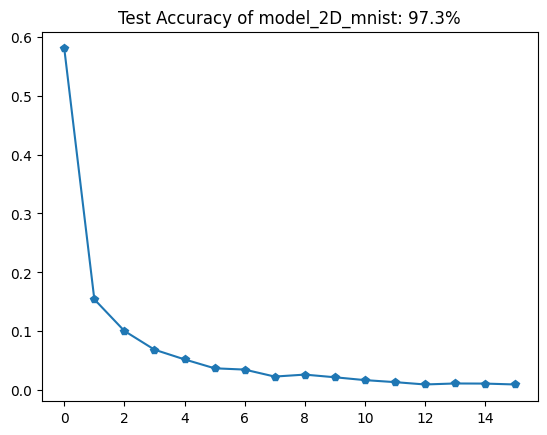

1/1 [==============================] - 0s 21ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8
pred: 0, label: 0
pred: 3, label: 3
pred: 9, label: 9
pred: 4, label: 4
pred: 2, label: 2


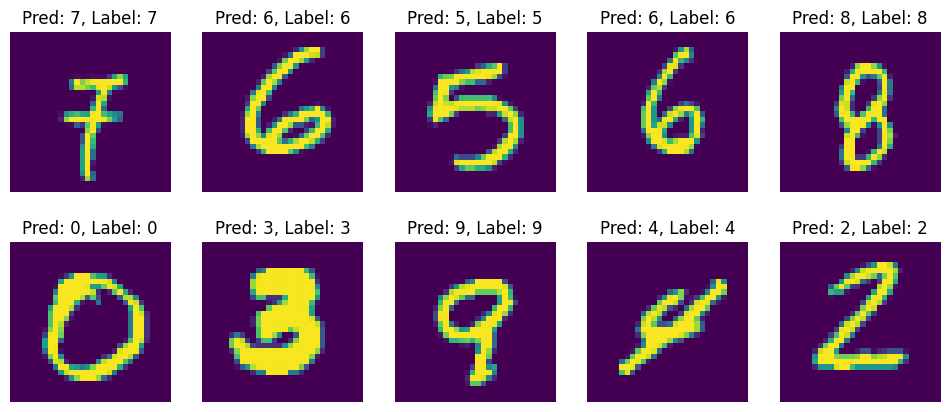

In [11]:
# Model to predict score for 128 features for MNIST
feats_extracted_2D = Input(shape= feat_2d.shape[1:])  
output_pred_2D = Dense(num_classes, activation="softmax")(feats_extracted_2D)
model_pred_scores_2D = Model(feats_extracted_2D, output_pred_2D)
# model_pred_scores_2D.summary()

# Model 2D CNN-based Classifier for MNIST 2D
# Complete CNN model for MNIST 2D Dataset
model_2D_mnist = keras.Model(inputs_2D, model_pred_scores_2D(model_feat_ext_2D(inputs_2D)))
model_2D_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model_2D_mnist.summary())


model_name = 'model_2D_mnist'
model = model_2D_mnist
model_type = '2D'
# epochs = 2 
# batch_size = 32
# patience = 5
x_train = x_train_2d
x_test = x_test_2d

# Train and evaluate...
model_eval_dict[model_name]= train_and_evaluate(
    model_name, model_2D_mnist, x_train, x_test, y_train, y_test, 
    epochs, batch_size, patience)

# # Visualize the prediction on 3D point clouds
visualize_prediction(model_name, model_type, model_2D_mnist)

## Creating 3D Pointnet-based Classifier

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024, 3)]         0         
                                                                 
 feature-extractor-3D (Funct  (None, 128)              747689    
 ional)                                                          
                                                                 
 model_2 (Functional)        (None, 10)                1290      
                                                                 
Total params: 748,979
Trainable params: 742,899
Non-trainable params: 6,080
_________________________________________________________________
None
Epoch 1/500
141/141 [==============================] - 163s 1s/step - loss: 0.9927 - accuracy: 0.6798 - val_loss: 1.4233 - val_accuracy: 0.6840
Epoch 2/500
141/141 [==============================] - 196s 1s/step - loss: 0.5502 - accuracy: 0.8

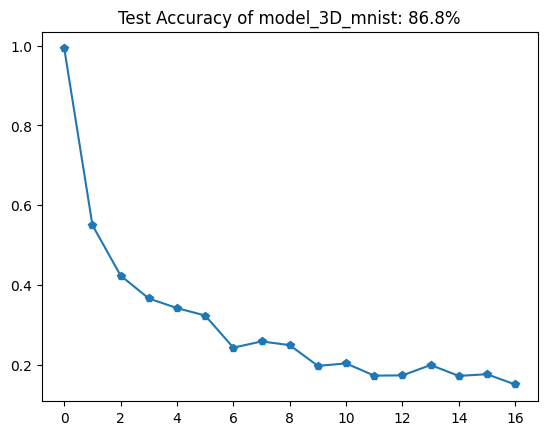

1/1 [==============================] - 0s 74ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8
pred: 0, label: 0
pred: 3, label: 3
pred: 9, label: 9
pred: 7, label: 4
pred: 2, label: 2


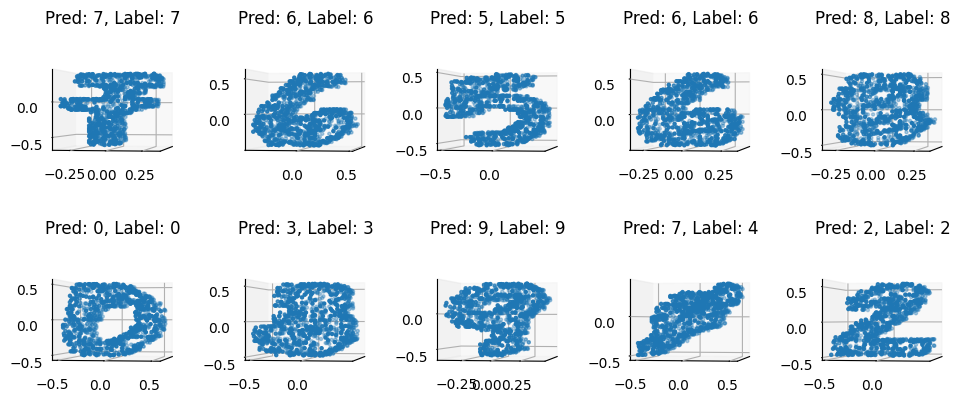

In [12]:
# Model to predict score for 128 features for MNIST 3D dataset
feats_extracted_3D = Input(shape= feat_3D.shape[1:])  
output_pred_3D = Dense(num_classes, activation="softmax")(feats_extracted_3D)
model_pred_scores_3D = Model(feats_extracted_3D, output_pred_3D)
# model_pred_scores_3D.summary()

# Model Pointnet Classifier for MNIST 3D
model_3D_mnist = keras.Model(inputs_3D, model_pred_scores_3D(model_feat_ext_3D(inputs_3D)))
model_3D_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model_3D_mnist.summary())




model_name = 'model_3D_mnist'
model = model_3D_mnist
model_type = '3D'
# epochs = 1 
# batch_size = 32
# patience = 5
x_train = x_train_3d
x_test = x_test_3d

# Train and evaluate...
model_eval_dict[model_name]= train_and_evaluate(
    model_name, model, x_train, x_test, y_train, y_test, 
    epochs, batch_size, patience)

# # Visualize the prediction on 3D point clouds
visualize_prediction(model_name, model_type, model)

# Create Fusion Models

In [13]:
# Create Late Fusion Models with different fusion layers
from keras.layers import Concatenate, Average,Maximum, Minimum, Add, Subtract, Multiply

mid_fusion_layers_dict = {
    'concatenate': Concatenate(),
    'Average' : Average(),
    'Maximum' : Maximum(),
    'Minimum' : Minimum(),
    'Add': Add(),
    'Subtract': Subtract(),
    'Multiply': Multiply()
}


late_fusion_layers_dict = {
    'Average' : Average(),
    'Maximum' : Maximum(),
    'Minimum' : Minimum(),
    'Add': Add(),
    'Subtract': Subtract(),
    'Multiply': Multiply()
}

In [14]:
model_feat_ext_2D.trainable = False
model_feat_ext_3D.trainable = False

model_pred_scores_2D.trainable = False
model_pred_scores_3D.trainable = False

model_2D_mnist.trainable = False
model_3D_mnist.trainable = False

# model_feat_ext_2D.trainable = True
# model_feat_ext_3D.trainable = True

# model_pred_scores_2D.trainable = True
# model_pred_scores_3D.trainable = True

# model_2D_mnist.trainable = True
# model_3D_mnist.trainable = True

## Creating Late-Fusion Models

Average
Epoch 1/500
141/141 [==============================] - 21s 136ms/step - loss: 0.0670 - accuracy: 0.9949 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 2/500
141/141 [==============================] - 19s 132ms/step - loss: 0.0655 - accuracy: 0.9953 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 3/500
141/141 [==============================] - 19s 133ms/step - loss: 0.0669 - accuracy: 0.9947 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 4/500
141/141 [==============================] - 20s 142ms/step - loss: 0.0663 - accuracy: 0.9962 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 5/500
141/141 [==============================] - 19s 137ms/step - loss: 0.0657 - accuracy: 0.9949 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 6/500
18/18 [==============================] - 3s 171ms/step - loss: 0.1603 - accuracy: 0.9710
Test Accuracy of model_late_fusion_mnist_Average: 97.1%


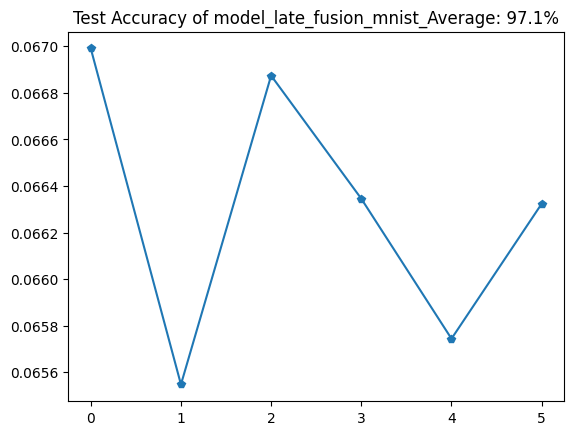

1/1 [==============================] - 0s 58ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


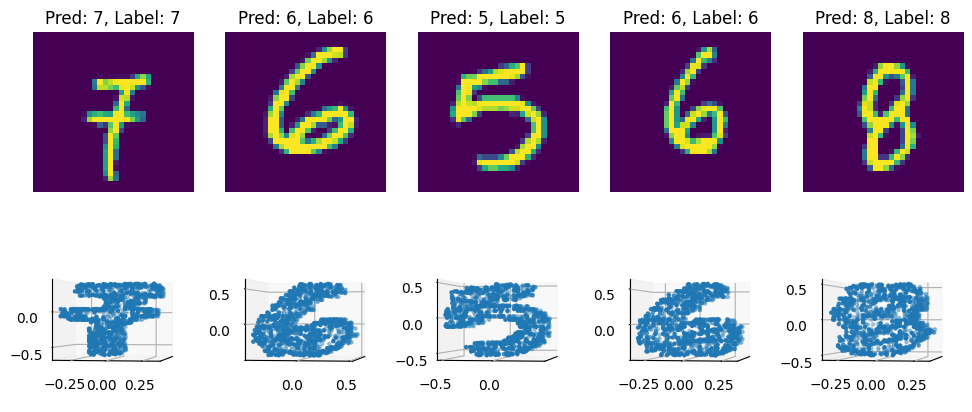

Maximum
Epoch 1/500
141/141 [==============================] - 21s 137ms/step - loss: 0.0835 - accuracy: 0.9947 - val_loss: 0.1434 - val_accuracy: 0.9700
Epoch 2/500
141/141 [==============================] - 19s 134ms/step - loss: 0.0818 - accuracy: 0.9953 - val_loss: 0.1434 - val_accuracy: 0.9700
Epoch 3/500
141/141 [==============================] - 18s 131ms/step - loss: 0.0833 - accuracy: 0.9942 - val_loss: 0.1434 - val_accuracy: 0.9700
Epoch 4/500
141/141 [==============================] - 19s 137ms/step - loss: 0.0832 - accuracy: 0.9956 - val_loss: 0.1434 - val_accuracy: 0.9700
Epoch 5/500
141/141 [==============================] - 19s 136ms/step - loss: 0.0824 - accuracy: 0.9944 - val_loss: 0.1434 - val_accuracy: 0.9700
Epoch 6/500
18/18 [==============================] - 3s 176ms/step - loss: 0.1756 - accuracy: 0.9700
Test Accuracy of model_late_fusion_mnist_Maximum: 97.0%


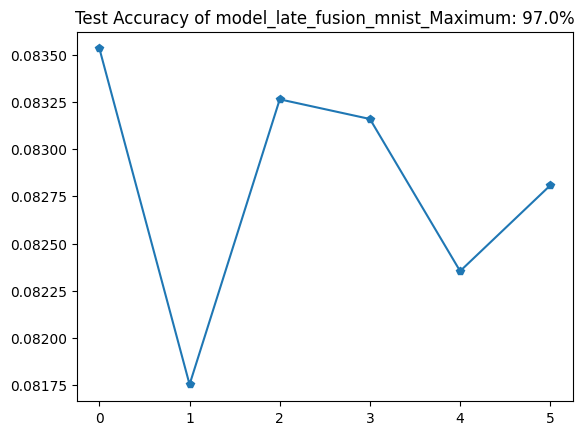

1/1 [==============================] - 0s 44ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


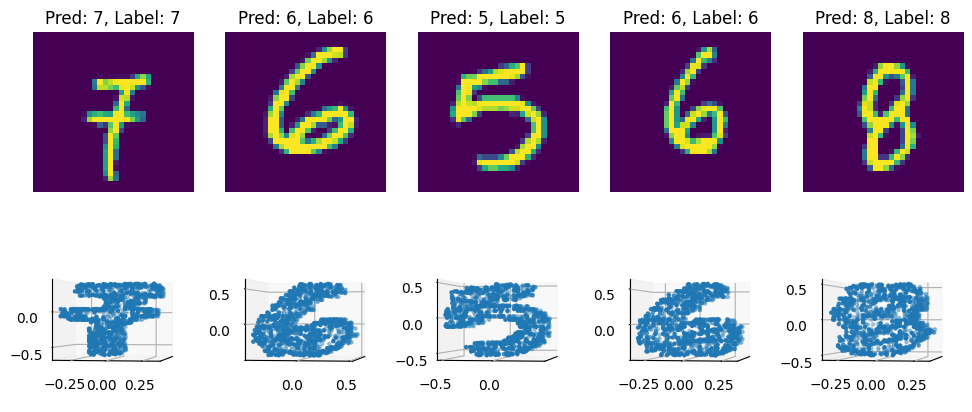

Minimum
Epoch 1/500
141/141 [==============================] - 22s 139ms/step - loss: 0.0123 - accuracy: 0.9962 - val_loss: 0.1315 - val_accuracy: 0.9700
Epoch 2/500
141/141 [==============================] - 20s 139ms/step - loss: 0.0114 - accuracy: 0.9949 - val_loss: 0.1315 - val_accuracy: 0.9700
Epoch 3/500
141/141 [==============================] - 22s 153ms/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.1315 - val_accuracy: 0.9700
Epoch 4/500
141/141 [==============================] - 21s 150ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.1315 - val_accuracy: 0.9700
Epoch 5/500
141/141 [==============================] - 21s 150ms/step - loss: 0.0118 - accuracy: 0.9944 - val_loss: 0.1315 - val_accuracy: 0.9700
Epoch 6/500
18/18 [==============================] - 3s 187ms/step - loss: 0.1341 - accuracy: 0.9680
Test Accuracy of model_late_fusion_mnist_Minimum: 96.8%


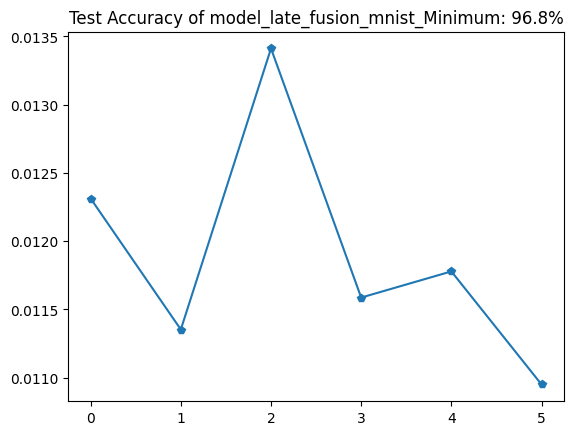

1/1 [==============================] - 0s 59ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


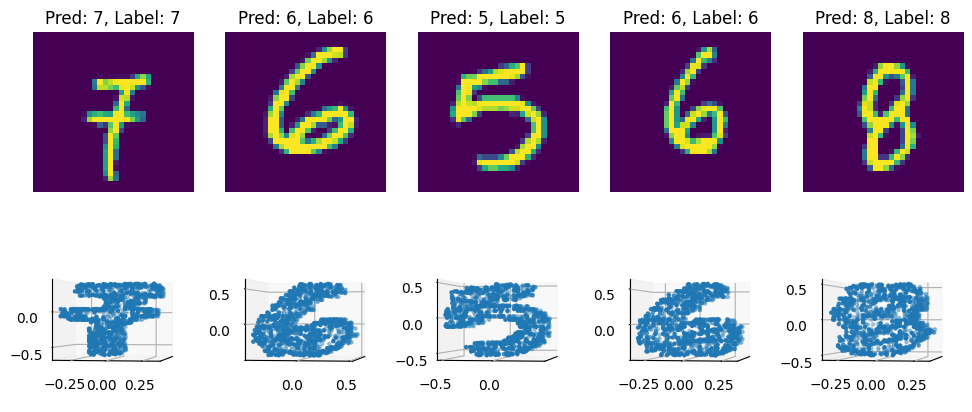

Add
Epoch 1/500
141/141 [==============================] - 24s 155ms/step - loss: 0.0670 - accuracy: 0.9949 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 2/500
141/141 [==============================] - 21s 148ms/step - loss: 0.0655 - accuracy: 0.9953 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 3/500
141/141 [==============================] - 21s 149ms/step - loss: 0.0669 - accuracy: 0.9947 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 4/500
141/141 [==============================] - 20s 144ms/step - loss: 0.0663 - accuracy: 0.9962 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 5/500
141/141 [==============================] - 21s 152ms/step - loss: 0.0657 - accuracy: 0.9949 - val_loss: 0.1327 - val_accuracy: 0.9720
Epoch 6/500
18/18 [==============================] - 4s 201ms/step - loss: 0.1603 - accuracy: 0.9710
Test Accuracy of model_late_fusion_mnist_Add: 97.1%


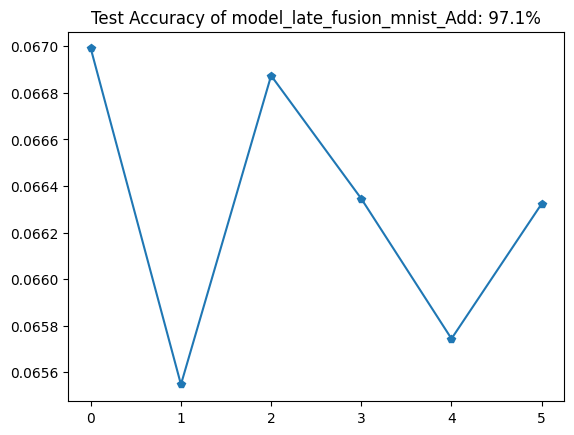

1/1 [==============================] - 0s 67ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


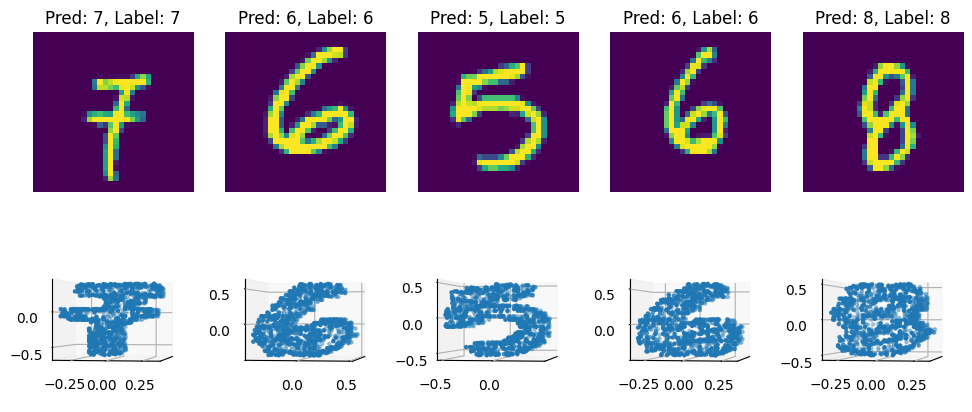

Subtract
Epoch 1/500
141/141 [==============================] - 26s 172ms/step - loss: 7.5361 - accuracy: 0.8229 - val_loss: 7.0920 - val_accuracy: 0.8340
Epoch 2/500
141/141 [==============================] - 23s 162ms/step - loss: 7.4251 - accuracy: 0.8229 - val_loss: 7.0920 - val_accuracy: 0.8340
Epoch 3/500
141/141 [==============================] - 23s 162ms/step - loss: 7.5361 - accuracy: 0.8298 - val_loss: 7.0920 - val_accuracy: 0.8340
Epoch 4/500
141/141 [==============================] - 23s 164ms/step - loss: 7.4897 - accuracy: 0.8296 - val_loss: 7.0920 - val_accuracy: 0.8340
Epoch 5/500
141/141 [==============================] - 22s 158ms/step - loss: 7.3714 - accuracy: 0.8273 - val_loss: 7.0920 - val_accuracy: 0.8340
Epoch 6/500
18/18 [==============================] - 4s 208ms/step - loss: 7.8660 - accuracy: 0.7810
Test Accuracy of model_late_fusion_mnist_Subtract: 78.1%


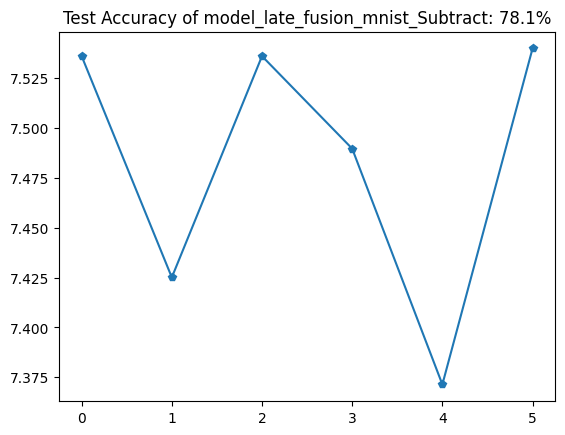

1/1 [==============================] - 0s 57ms/step
pred: 8, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


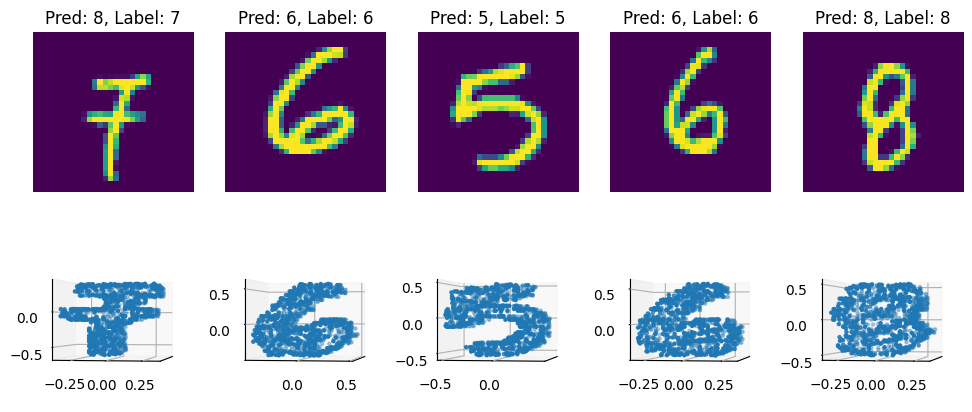

Multiply
Epoch 1/500
141/141 [==============================] - 25s 165ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.1375 - val_accuracy: 0.9740
Epoch 2/500
141/141 [==============================] - 23s 162ms/step - loss: 0.0098 - accuracy: 0.9962 - val_loss: 0.1375 - val_accuracy: 0.9740
Epoch 3/500
141/141 [==============================] - 23s 164ms/step - loss: 0.0127 - accuracy: 0.9964 - val_loss: 0.1375 - val_accuracy: 0.9740
Epoch 4/500
141/141 [==============================] - 23s 167ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.1375 - val_accuracy: 0.9740
Epoch 5/500
141/141 [==============================] - 23s 167ms/step - loss: 0.0106 - accuracy: 0.9956 - val_loss: 0.1375 - val_accuracy: 0.9740
Epoch 6/500
18/18 [==============================] - 4s 202ms/step - loss: 0.1706 - accuracy: 0.9690
Test Accuracy of model_late_fusion_mnist_Multiply: 96.9%


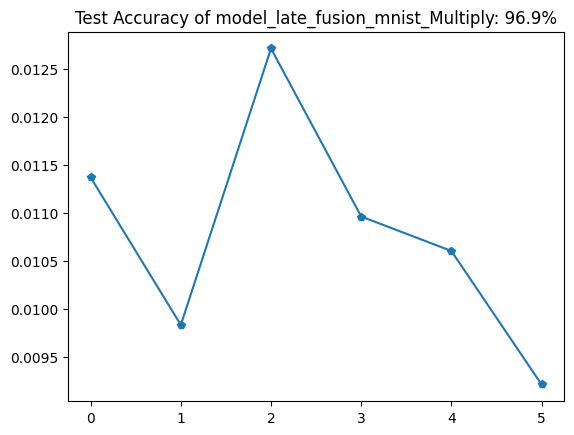

1/1 [==============================] - 0s 55ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


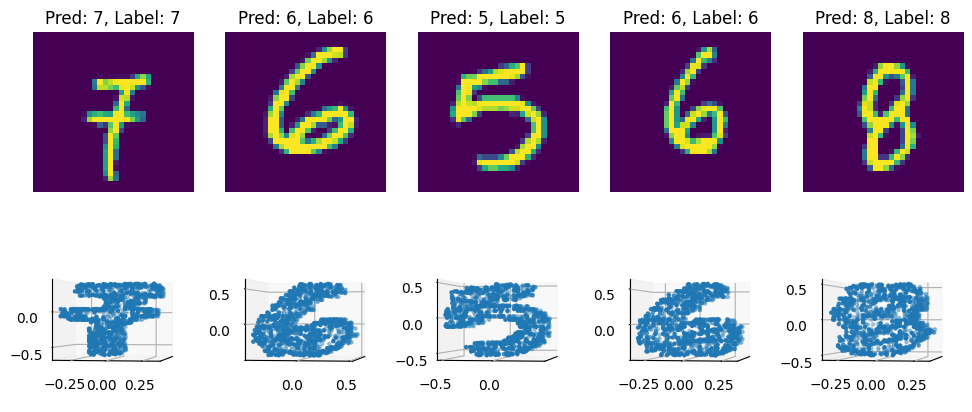

In [15]:
for fusion_layer_name, fusion_layer in late_fusion_layers_dict.items():

    print(fusion_layer_name)
    model_name = f"model_late_fusion_mnist_{fusion_layer_name}"
    
    # combine the output of the two branches
    output_pred_late_fusion = fusion_layer([model_2D_mnist.output, model_3D_mnist.output])

    # Finally combine two models and build a single multi modal mode...
    model_late_fusion_mnist = Model(inputs=[inputs_2D, inputs_3D], outputs= output_pred_late_fusion,  name = model_name)
    model_late_fusion_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    # print(model_late_fusion_mnist.summary())

    model_name = model_name
    model = model_late_fusion_mnist
    model_type = 'Fusion'
    # epochs = 2 
    # batch_size = 32
    # patience = 5
    x_train = [x_train_2d, x_train_3d]
    x_test = [x_test_2d, x_test_3d]

    # Train and evaluate...
    model_eval_dict[model_name]= train_and_evaluate(
        model_name, model, x_train, x_test, y_train, y_test, 
        epochs, batch_size, patience)

    # # Visualize the prediction on 3D point clouds
    visualize_prediction(model_name, model_type, model)

## Creating Mid Fusion Models

concatenate
Epoch 1/500
141/141 [==============================] - 77s 531ms/step - loss: 0.1556 - accuracy: 0.9629 - val_loss: 0.1041 - val_accuracy: 0.9680
Epoch 2/500
141/141 [==============================] - 25s 176ms/step - loss: 0.0111 - accuracy: 0.9969 - val_loss: 0.1004 - val_accuracy: 0.9700
Epoch 3/500
141/141 [==============================] - 24s 168ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.1033 - val_accuracy: 0.9720
Epoch 4/500
141/141 [==============================] - 22s 158ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.1300 - val_accuracy: 0.9700
Epoch 5/500
141/141 [==============================] - 21s 152ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1201 - val_accuracy: 0.9740
Epoch 6/500
141/141 [==============================] - 22s 154ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.1129 - val_accuracy: 0.9740
Epoch 7/500
18/18 [==============================] - 4s 197ms/step - loss: 0.1320 - accuracy: 0.9740
Test Accura

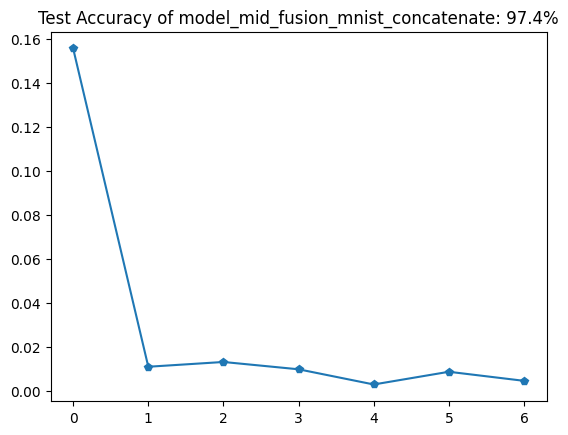

1/1 [==============================] - 0s 44ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


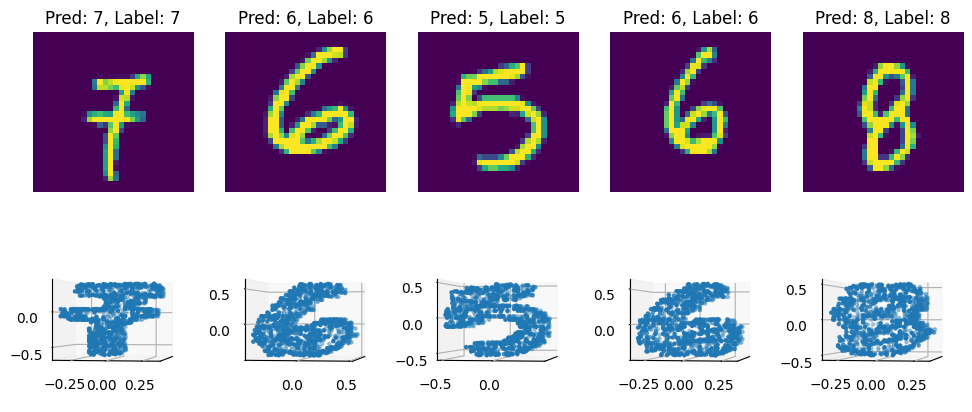

Average
Epoch 1/500
141/141 [==============================] - 24s 158ms/step - loss: 0.2470 - accuracy: 0.9391 - val_loss: 0.0989 - val_accuracy: 0.9720
Epoch 2/500
141/141 [==============================] - 22s 156ms/step - loss: 0.0176 - accuracy: 0.9967 - val_loss: 0.0889 - val_accuracy: 0.9760
Epoch 3/500
141/141 [==============================] - 22s 157ms/step - loss: 0.0122 - accuracy: 0.9971 - val_loss: 0.1099 - val_accuracy: 0.9700
Epoch 4/500
141/141 [==============================] - 21s 152ms/step - loss: 0.0086 - accuracy: 0.9984 - val_loss: 0.0935 - val_accuracy: 0.9800
Epoch 5/500
141/141 [==============================] - 22s 154ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 0.1150 - val_accuracy: 0.9720
Epoch 6/500
141/141 [==============================] - 22s 155ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.1123 - val_accuracy: 0.9780
Epoch 7/500
18/18 [==============================] - 4s 200ms/step - loss: 0.0988 - accuracy: 0.9770
Test Accuracy o

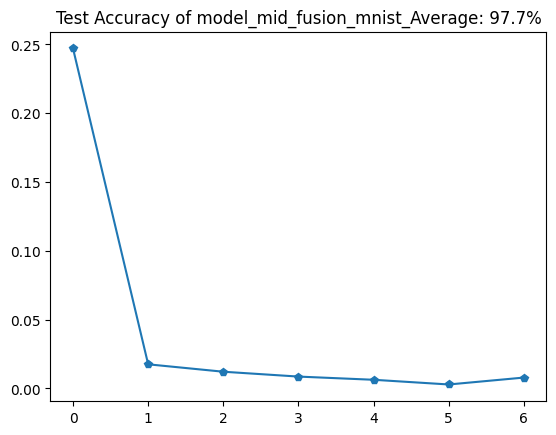

1/1 [==============================] - 0s 39ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


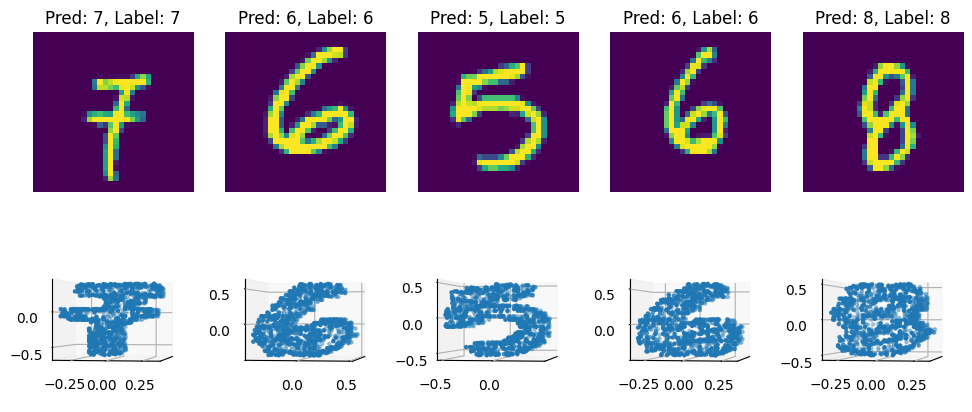

Maximum
Epoch 1/500
141/141 [==============================] - 24s 160ms/step - loss: 0.2352 - accuracy: 0.9404 - val_loss: 0.1195 - val_accuracy: 0.9660
Epoch 2/500
141/141 [==============================] - 22s 153ms/step - loss: 0.0163 - accuracy: 0.9967 - val_loss: 0.1037 - val_accuracy: 0.9780
Epoch 3/500
141/141 [==============================] - 22s 159ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.1272 - val_accuracy: 0.9700
Epoch 4/500
141/141 [==============================] - 23s 160ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.1180 - val_accuracy: 0.9740
Epoch 5/500
141/141 [==============================] - 23s 161ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.1147 - val_accuracy: 0.9780
Epoch 6/500
141/141 [==============================] - 22s 158ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.1384 - val_accuracy: 0.9700
Epoch 7/500
18/18 [==============================] - 4s 221ms/step - loss: 0.1286 - accuracy: 0.9690
Test Accuracy o

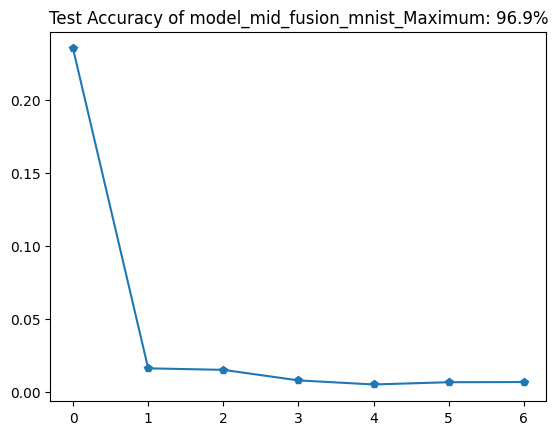

1/1 [==============================] - 0s 57ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


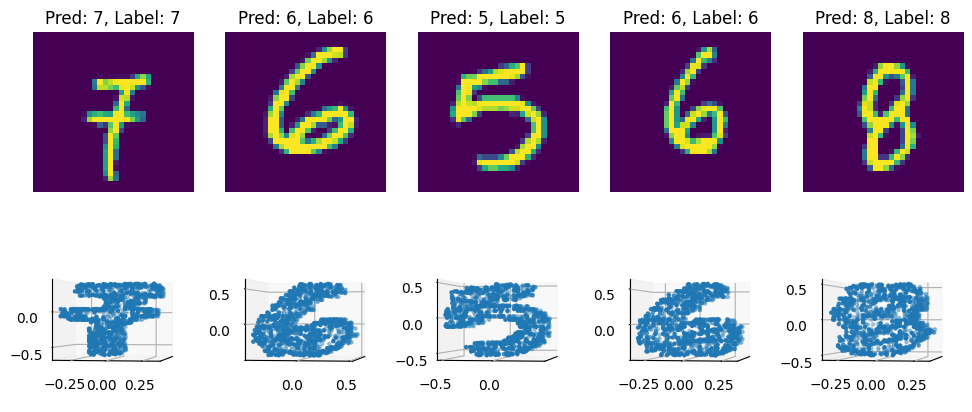

Minimum
Epoch 1/500
141/141 [==============================] - 27s 173ms/step - loss: 0.4611 - accuracy: 0.8882 - val_loss: 0.1704 - val_accuracy: 0.9600
Epoch 2/500
141/141 [==============================] - 23s 161ms/step - loss: 0.0417 - accuracy: 0.9889 - val_loss: 0.1782 - val_accuracy: 0.9620
Epoch 3/500
141/141 [==============================] - 21s 148ms/step - loss: 0.0267 - accuracy: 0.9929 - val_loss: 0.1755 - val_accuracy: 0.9600
Epoch 4/500
141/141 [==============================] - 21s 146ms/step - loss: 0.0253 - accuracy: 0.9916 - val_loss: 0.1804 - val_accuracy: 0.9600
Epoch 5/500
141/141 [==============================] - 22s 153ms/step - loss: 0.0237 - accuracy: 0.9916 - val_loss: 0.1822 - val_accuracy: 0.9600
Epoch 6/500
141/141 [==============================] - 21s 150ms/step - loss: 0.0164 - accuracy: 0.9942 - val_loss: 0.1677 - val_accuracy: 0.9600
Epoch 7/500
141/141 [==============================] - 21s 149ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 

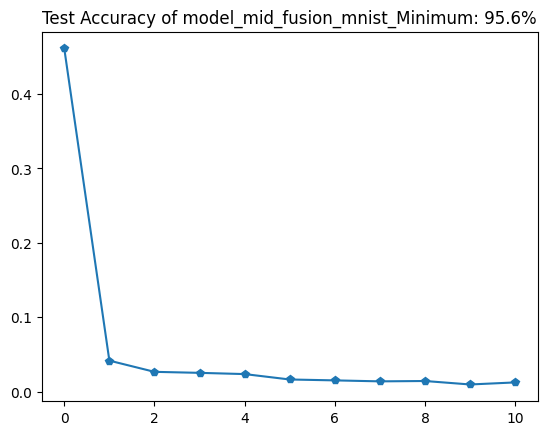

1/1 [==============================] - 0s 36ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


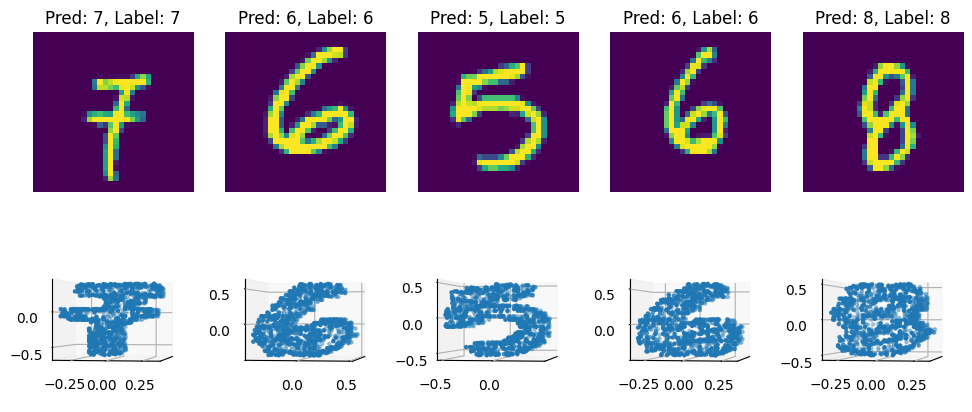

Add
Epoch 1/500
141/141 [==============================] - 24s 158ms/step - loss: 0.2416 - accuracy: 0.9389 - val_loss: 0.1105 - val_accuracy: 0.9720
Epoch 2/500
141/141 [==============================] - 22s 155ms/step - loss: 0.0147 - accuracy: 0.9967 - val_loss: 0.1020 - val_accuracy: 0.9700
Epoch 3/500
141/141 [==============================] - 22s 153ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 0.1166 - val_accuracy: 0.9700
Epoch 4/500
141/141 [==============================] - 22s 155ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.1046 - val_accuracy: 0.9820
Epoch 5/500
141/141 [==============================] - 23s 166ms/step - loss: 0.0063 - accuracy: 0.9976 - val_loss: 0.1026 - val_accuracy: 0.9760
Epoch 6/500
141/141 [==============================] - 28s 201ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.1179 - val_accuracy: 0.9800
Epoch 7/500
18/18 [==============================] - 5s 271ms/step - loss: 0.1089 - accuracy: 0.9760
Test Accuracy of mo

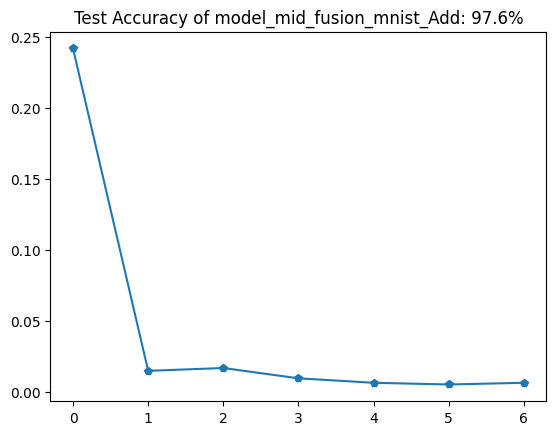

1/1 [==============================] - 0s 50ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


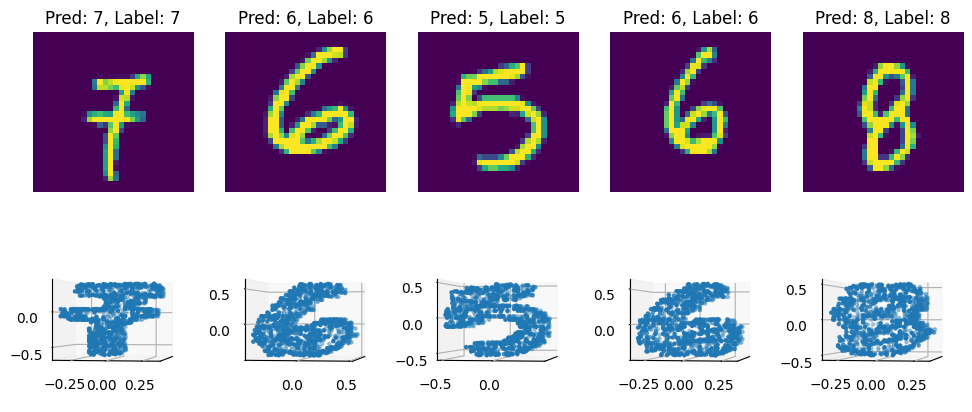

Subtract
Epoch 1/500
141/141 [==============================] - 33s 215ms/step - loss: 0.1749 - accuracy: 0.9542 - val_loss: 0.1511 - val_accuracy: 0.9660
Epoch 2/500
141/141 [==============================] - 29s 207ms/step - loss: 0.0135 - accuracy: 0.9964 - val_loss: 0.1280 - val_accuracy: 0.9720
Epoch 3/500
141/141 [==============================] - 30s 211ms/step - loss: 0.0145 - accuracy: 0.9947 - val_loss: 0.1558 - val_accuracy: 0.9640
Epoch 4/500
141/141 [==============================] - 30s 216ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 0.1242 - val_accuracy: 0.9760
Epoch 5/500
141/141 [==============================] - 30s 215ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.1253 - val_accuracy: 0.9780
Epoch 6/500
141/141 [==============================] - 31s 218ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1376 - val_accuracy: 0.9760
Epoch 7/500
141/141 [==============================] - 30s 214ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss:

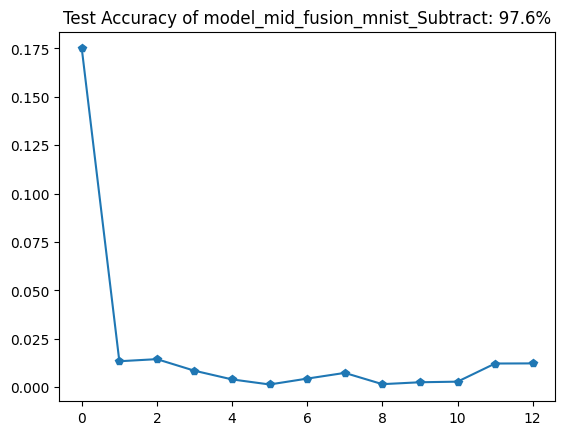

1/1 [==============================] - 0s 70ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


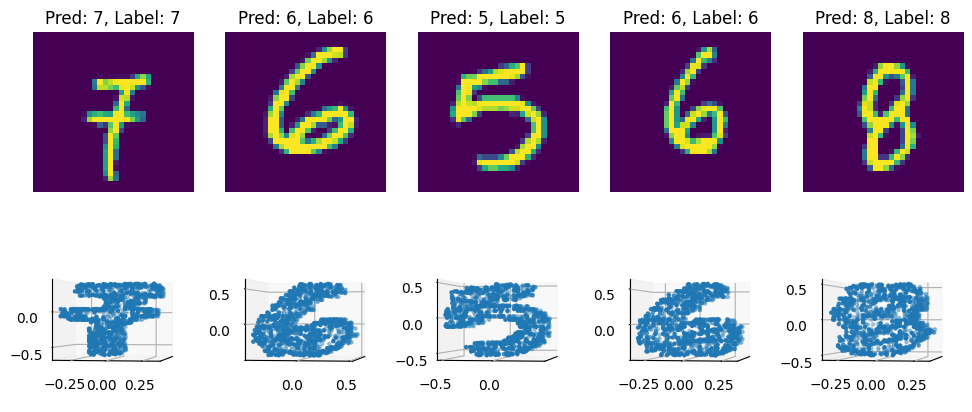

Multiply
Epoch 1/500
141/141 [==============================] - 32s 205ms/step - loss: 0.3129 - accuracy: 0.9191 - val_loss: 0.1576 - val_accuracy: 0.9620
Epoch 2/500
141/141 [==============================] - 30s 215ms/step - loss: 0.0376 - accuracy: 0.9896 - val_loss: 0.1640 - val_accuracy: 0.9580
Epoch 3/500
141/141 [==============================] - 31s 220ms/step - loss: 0.0192 - accuracy: 0.9956 - val_loss: 0.1693 - val_accuracy: 0.9680
Epoch 4/500
141/141 [==============================] - 31s 220ms/step - loss: 0.0216 - accuracy: 0.9929 - val_loss: 0.1849 - val_accuracy: 0.9600
Epoch 5/500
141/141 [==============================] - 24s 168ms/step - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.1897 - val_accuracy: 0.9680
Epoch 6/500
141/141 [==============================] - 21s 150ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.1501 - val_accuracy: 0.9760
Epoch 7/500
141/141 [==============================] - 21s 149ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss:

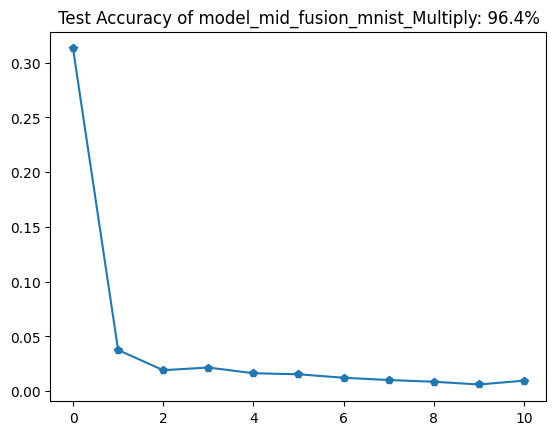

1/1 [==============================] - 0s 36ms/step
pred: 7, label: 7
pred: 6, label: 6
pred: 5, label: 5
pred: 6, label: 6
pred: 8, label: 8


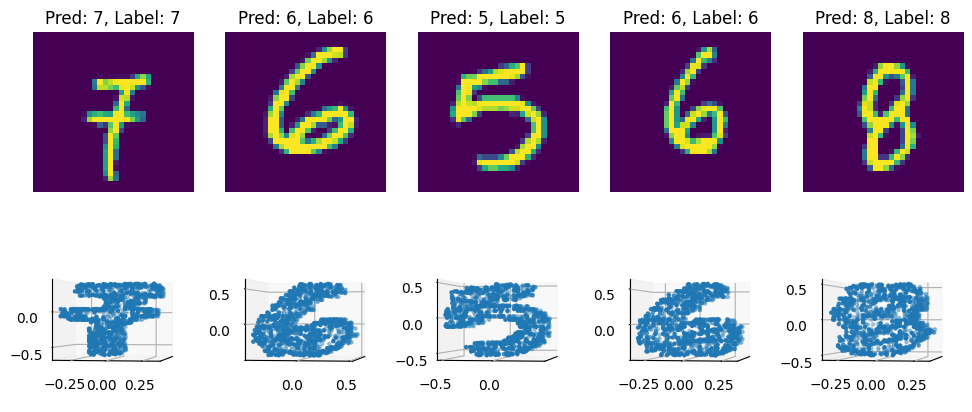

In [16]:
for fusion_layer_name, fusion_layer in mid_fusion_layers_dict.items():

    print(fusion_layer_name)
    model_name = f"model_mid_fusion_mnist_{fusion_layer_name}"
    
    # combine the output of the two branches
    output_pred_mid_fusion = fusion_layer([model_feat_ext_2D.output, model_feat_ext_3D.output])
    output_pred_mid_fusion = Dense(128, activation="relu")(output_pred_mid_fusion)
    output_pred_mid_fusion = Dense(64, activation="relu")(output_pred_mid_fusion)
    output_pred_mid_fusion = Dense(num_classes, activation="softmax")(output_pred_mid_fusion)

    # Finally combine two models and build a single multi modal mode...
    model_mid_fusion_mnist = Model(inputs=[inputs_2D, inputs_3D], outputs= output_pred_mid_fusion,  name = model_name)
    model_mid_fusion_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    # print(model_late_fusion_mnist.summary())

    model_name = model_name
    model = model_mid_fusion_mnist
    model_type = 'Fusion'
    # epochs = 2 
    # batch_size = 32
    # patience = 5
    x_train = [x_train_2d, x_train_3d]
    x_test = [x_test_2d, x_test_3d]

    # Train and evaluate...
    model_eval_dict[model_name]= train_and_evaluate(
        model_name, model, x_train, x_test, y_train, y_test, 
        epochs, batch_size, patience)

    # # Visualize the prediction on 3D point clouds
    visualize_prediction(model_name, model_type, model)

In [25]:
accuracy_list = []
for key in model_eval_dict.keys():
    accuracy_list.append([key, model_eval_dict[key]['accuracy']])
accuracy_df = pd.DataFrame(accuracy_list, columns = ['Name', 'Accuracy'])

<AxesSubplot: xlabel='Accuracy', ylabel='Name'>

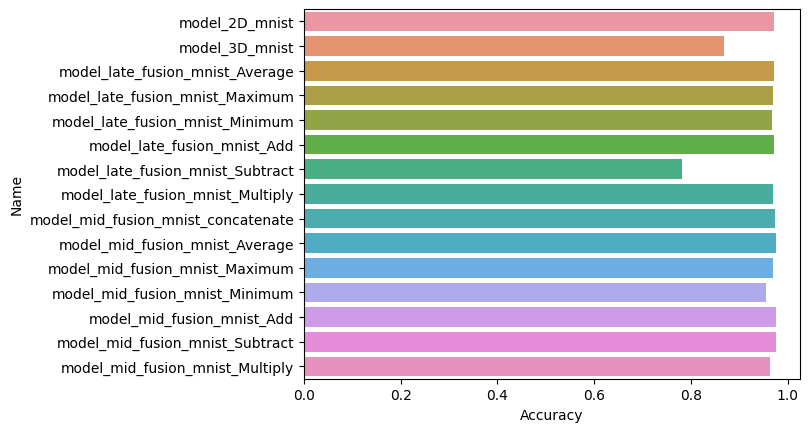

In [26]:
sns.barplot(accuracy_df, y = "Name", x = "Accuracy")